In [4]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import timedelta
import math


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from sagemaker import image_uris


In [5]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [6]:
sagemaker_session = sagemaker.Session()


In [7]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_bucket_prefix = (
    "deepar-retail-notebook"  # prefix used for all data stored within the bucket
)
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    s3_prefix = s3_bucket_prefix

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [8]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [9]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)


[05/09/25 18:05:35] INFO     Same images used for training and inference. Defaulting to image     ]8;id=234053;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146316;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=571858;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=91161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [10]:
online_retail_df = pd.read_json('online_retail.json')
online_retail_df

,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


In [11]:
formatted_df = online_retail_df.rename(columns={
    'Description': 'ProductId'
})
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df.loc[:,'TimeIdx'] = formatted_df.groupby("ProductId").cumcount()
formatted_df = formatted_df[['Date','TimeIdx', 'ProductId', 'UnitsSold']].reset_index()
formatted_df['UnitsSold'] = formatted_df['UnitsSold'].astype(float)
formatted_df


,index,Date,TimeIdx,ProductId,UnitsSold
0,0,2009-12-01,0,12 pencils small tube red spotty,45.0
1,739,2009-12-01,0,12 pencils tall tube posy,69.0
2,1478,2009-12-01,0,12 pencils tall tube woodland,4.0
3,2217,2009-12-01,0,6 ribbons rustic charm,27.0
4,2956,2009-12-01,0,60 teatime fairy cake cases,173.0
...,...,...,...,...,...
104933,104198,2011-12-09,738,wooden rounders garden set,0.0
104934,102720,2011-12-09,738,wooden school colouring set,13.0
104935,74638,2011-12-09,738,woodland charlotte bag,40.0
104936,75377,2011-12-09,738,world war 2 gliders asstd designs,49.0


In [12]:
import numpy as np
import pandas as pd

freq = "D"
train_end_date = formatted_df['Date'].max() - pd.Timedelta(days=30)

train_series = []
test_series = []

for product_id, df_group in formatted_df.groupby("ProductId"):
    df_group = df_group.sort_values("Date").reset_index(drop=True)

    # Create lag features
    df_group["lag_1"] = df_group["UnitsSold"].shift(1)
    df_group["lag_7"] = df_group["UnitsSold"].shift(7)
    df_group["lag_14"] = df_group["UnitsSold"].shift(14)

    # Fill NaNs in lag features with 0
    df_group[["lag_1", "lag_7", "lag_14"]] = df_group[["lag_1", "lag_7", "lag_14"]].fillna(0)

    # Full target and log transform
    target = df_group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    # Get dynamic features as list of lists
    feat_dynamic_real = df_group[["lag_1", "lag_7", "lag_14"]].T.values.tolist()

    # Split for train/test
    train_df = df_group[df_group["Date"] <= train_end_date]
    test_df = df_group
    train_len = len(train_df)
    start_str = pd.Timestamp(df_group["Date"].iloc[0]).strftime("%Y-%m-%d")

    if train_len >= 30:
        train_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [f[:train_len] for f in feat_dynamic_real],
            "item_id": str(product_id)
        })

        test_series.append({
            "start": start_str,
            "target": target_log,
            "feat_dynamic_real": feat_dynamic_real,
            "item_id": str(product_id)
        })

In [15]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")












In [16]:
df = pd.read_json("test.json", lines=True)
df

,start,target,feat_dynamic_real,item_id
0,2009-12-01,"[3.828641396489095, 4.477336814478206, 3.55534...","[[0.0, 45.0, 87.0, 34.0, 84.0, 0.0, 49.0, 20.0...",12 pencils small tube red spotty
1,2009-12-01,"[4.2484952420493585, 4.477336814478206, 4.7621...","[[0.0, 69.0, 87.0, 116.0, 160.0, 24.0, 60.0, 7...",12 pencils tall tube posy
2,2009-12-01,"[1.6094379124341, 3.091042453358315, 2.6390573...","[[0.0, 4.0, 21.0, 13.0, 25.0, 0.0, 14.0, 10.0,...",12 pencils tall tube woodland
3,2009-12-01,"[3.3322045101752042, 2.079441541679835, 1.3862...","[[0.0, 27.0, 7.0, 3.0, 2.0, 0.0, 0.0, 5.0, 1.0...",6 ribbons rustic charm
4,2009-12-01,"[5.159055299214529, 5.075173815233827, 5.30826...","[[0.0, 173.0, 159.0, 201.0, 99.0, 0.0, 31.0, 5...",60 teatime fairy cake cases
...,...,...,...,...
137,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",wooden rounders garden set
138,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",wooden school colouring set
139,2009-12-01,"[3.555348061489413, 3.044522437723423, 2.39789...","[[0.0, 34.0, 20.0, 10.0, 14.0, 0.0, 0.0, 17.0,...",woodland charlotte bag
140,2009-12-01,"[3.891820298110626, 6.077642243349034, 4.04305...","[[0.0, 48.0, 435.0, 56.0, 144.0, 48.0, 0.0, 96...",world war 2 gliders asstd designs


In [17]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/09/25 18:14:56] INFO     Same images used for training and inference. Defaulting to image     ]8;id=98246;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=229258;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=588508;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=208496;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=471029;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=617889;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=167414;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=732052;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-09-18-14-56-720                                            

2025-05-09 18:14:56 Starting - Starting the training job...
2025-05-09 18:15:29 Starting - Preparing the instances for training...
2025-05-09 18:15:51 Downloading - Downloading input data...
2025-05-09 18:16:26 Downloading - Downloading the training image..................
2025-05-09 18:19:28 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/09/2025 18:19:33 INFO 140605520893760] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience

In [18]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/09/25 18:39:22] INFO     Creating model with name: forecasting-deepar-2025-05-09-18-39-22-301   ]8;id=800581;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=352944;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/09/25 18:39:23] INFO     Creating endpoint-config with name                                     ]8;id=888662;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=360663;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-09-18-39-22-301                                            

                    INFO     Creating endpoint with name forecasting-deepar-2025-05-09-18-39-22-301 ]8;id=481741;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=562275;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [19]:
import json
import numpy as np
from numpy import array

# Load the test set
data = []
with open("test.json") as f:
    for line in f:
        data.append(json.loads(line))

mape_list = []
smape_list = []
indices = []

prediction_length = 30  # should match your model's setting

for i in range(len(data)):
    series = data[i].copy()
    input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))
    
    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)
    log_actual = series["target"][-prediction_length:]
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # -- MAPE --
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # -- SMAPE --
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

        indices.append(i)

# Summary stats
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")
print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")


Mean MAPE: 97.95%
Mean SMAPE: 97.66%
MAPE range: 50.20% to 428.43%


In [20]:
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

74
25


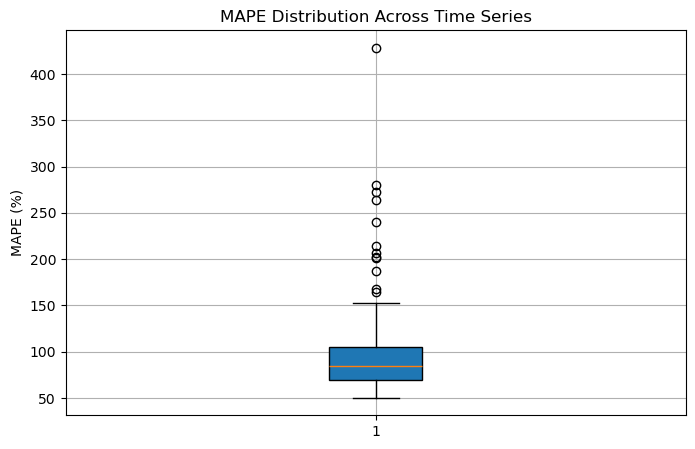

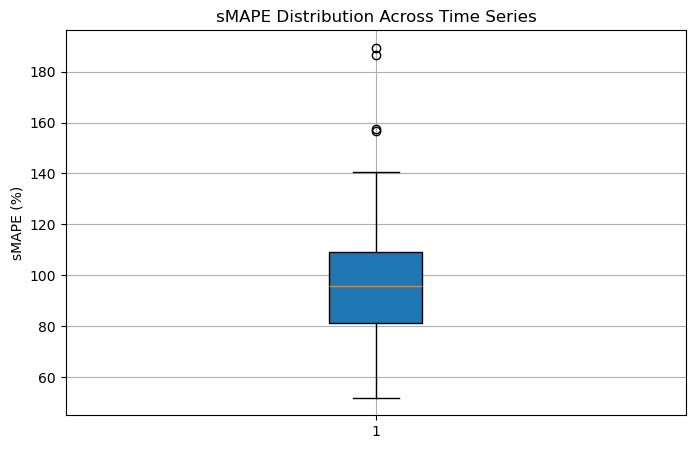

In [21]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

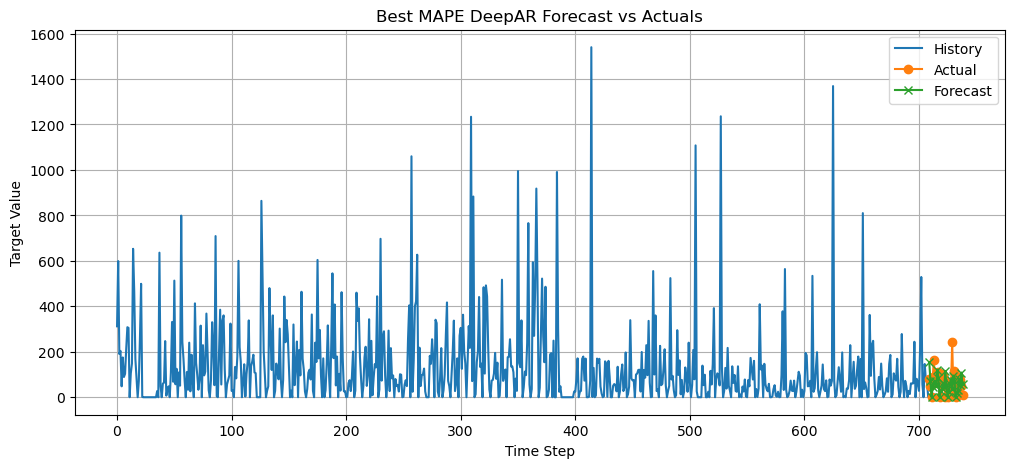

[ 78.  50.   0.  87. 164.  62.  89.  84. 109.   0.  82. 100.  99.  82.
   1.  45.   0.  15.  60.  52. 241.  29. 116.   0.  48.  42.  90.  74.
  51.   9.]
[1.53962749e+02 7.20267871e+01 8.85084661e-02 4.69884442e+01
 6.65657950e+01 7.04284883e+01 4.93706808e+01 1.21045772e+02
 8.48356602e+01 0.00000000e+00 2.58958158e+01 3.88621095e+01
 6.15850894e+01 4.30010940e+01 1.15637004e+02 4.85514518e+01
 0.00000000e+00 2.48896200e+01 5.73793506e+01 7.42803726e+01
 3.51493383e+01 9.51749362e+01 7.26869115e+01 0.00000000e+00
 1.92251238e+01 3.36159275e+01 8.18590491e+01 5.44357634e+01
 1.08647940e+02 5.69679776e+01]


In [22]:
import matplotlib.pyplot as plt
series = data[74].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

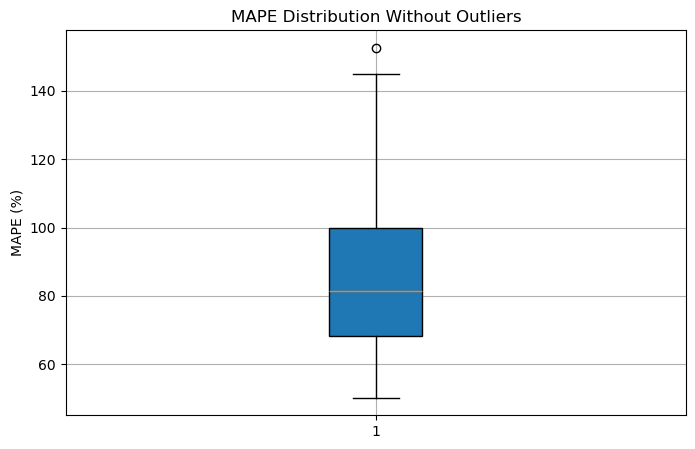

Average MAPE:  85.11427223606661


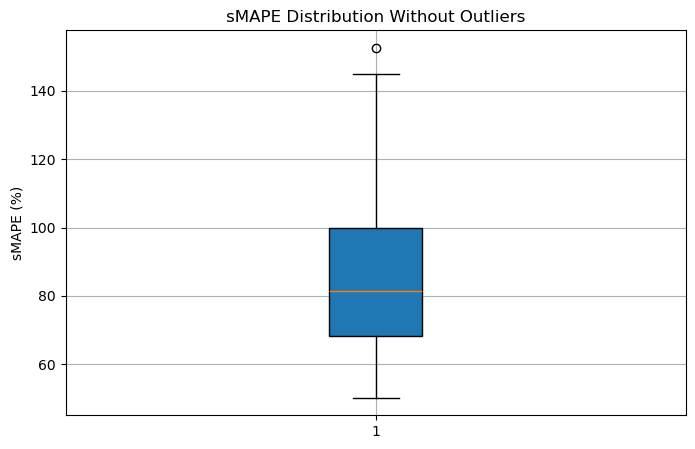

Average sMAPE:  95.47841209757765


In [23]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))